
# Tutorial: Tail Preprocessing 	&#x1F42C;

**The following notebook illustrate the `TailPreprocessing` class how to run the different preprocessing steps.**
- **Several preprocessing steps are used for the tail angle**:
  - Interpolating missing values
  - PCA denoising of posture using 'eigen-fish'
  - Savgol filter for time series smoothing
  - Baseline correction

- **The tail vigor is also computed and will also be useful for segmentation tail bouts**:



* Loading dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from megabouts.tracking_data import TrackingConfig, FullTrackingData, load_example_data
from megabouts.config import TailPreprocessingConfig
from megabouts.preprocessing import TailPreprocessing

## Loading Data

* TrackingConfig and TrackingData similar to [tutorial_Loading_Data](./Loading_Data.ipynb), here we use the dataset from the poorly trained SLEAP model to underlie the effect of smoothing.

In [3]:
# Load data and set tracking configuration
df_recording, fps, mm_per_unit = load_example_data('SLEAP_fulltracking')
tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

# List of keypoints
keypoints = ['left_eye', 'right_eye', 'tail0', 'tail1', 'tail2', 'tail3', 'tail4']

# Place NaN where the score is below a threshold
thresh_score = 0.
for kps in keypoints:
    score_below_thresh = df_recording['instance.score'] < thresh_score
    df_recording.loc[score_below_thresh | (df_recording[f'{kps}.score'] < thresh_score), [f'{kps}.x', f'{kps}.y']] = np.nan

# Compute head and tail coordinates and convert to mm
head_x = ((df_recording['left_eye.x'] + df_recording['right_eye.x']) / 2) * mm_per_unit
head_y = ((df_recording['left_eye.y'] + df_recording['right_eye.y']) / 2) * mm_per_unit
tail_x = df_recording[[f'tail{i}.x' for i in range(5)]].values * mm_per_unit
tail_y = df_recording[[f'tail{i}.y' for i in range(5)]].values * mm_per_unit

# Create FullTrackingData object
tracking_data = FullTrackingData.from_keypoints(head_x=head_x.values,
                                                head_y=head_y.values,
                                                tail_x=tail_x,
                                                tail_y=tail_y)


## Run Preprocessing

* Define preprocessing config using default:

In [4]:
tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps)

* Alternatively the tail preprocessing parameters can be adjusted using:

In [5]:
tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps,
                                                 num_pcs=3,
                                                 savgol_window_ms=30,
                                                 tail_speed_filter_ms = 100,
                                                 tail_speed_boxcar_filter_ms = 14
                                                 )

* Here we change the media filter for computing the tail baseline to 200 frame width:

In [6]:
tail_preprocessing_cfg.baseline_params['half_window']=100

* Let's run the preprocessing:

In [91]:
tail_df_input = tracking_data.tail_df
tail = TailPreprocessing(tail_preprocessing_cfg).preprocess_tail_df(tail_df_input)

* tail.df contains information about the raw angle, the baseline, the smooth angle as well as the vigor of the tail oscillations:

In [92]:
tail.df.head(5)

angle                                                              \
   segments                                                               
          0         1         2         3         4         5         6   
0  0.122614 -0.015221 -0.098553 -0.126124 -0.098301 -0.015937  0.062022   
1  0.122639 -0.015076 -0.098353 -0.125934 -0.098185 -0.015953  0.061969   
2  0.122712 -0.015160 -0.098521 -0.126112 -0.098298 -0.015927  0.062090   
3  0.182927  0.045016 -0.038378 -0.065993 -0.038198  0.044170  0.122267   
4  0.182883  0.045139 -0.038150 -0.065731 -0.037968  0.044304  0.122333   

                                 ... angle_smooth                      \
                                 ...     segments                       
          7         8         9  ...            2         3         4   
0  0.057392 -0.035583 -0.215341  ...    -0.103697 -0.100077 -0.069647   
1  0.057438 -0.035308 -0.214723  ...    -0.089520 -0.084504 -0.053630   
2  0.057466 -0.035575 -0.215469  ...    -0.080425 -0.074525 -0.043393   
3  0.117708  0.024690 -0.155223  ...    -0.076411 -0.070140 -0.038937   
4  0.117786  0.024859 -0.154890  ...    -0.077478 -0.071350 -0.040262   

                                                    vigor no_tracking  
                                                                       
          5         6         7         8         9                    
0 -0.020243  0.057969  0.061299 -0.090701 -0.173166   NaN       False  
1 -0.004097  0.071639  0.073541 -0.076892 -0.157914   NaN       False  
2  0.006204  0.080289  0.081271 -0.068089 -0.148180   NaN       False  
3  0.010658  0.083920  0.084489 -0.064291 -0.143965   NaN       False  
4  0.009267  0.082530  0.083194 -0.065499 -0.145269   NaN       False  

[5 rows x 32 columns]

* We can visualize the result of preprocessing:

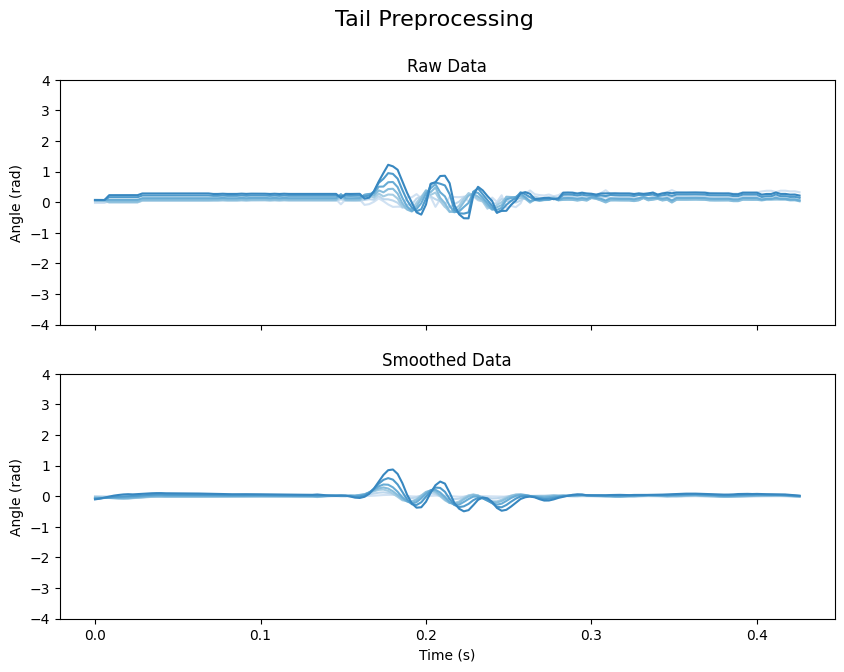

In [94]:
from cycler import cycler
blue_cycler = cycler(color=plt.cm.Blues(np.linspace(.2, .9, 10)))

t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = 140612#np.random.randint(tracking_data.T)
Duration = 150
t_win = t[IdSt:IdSt+Duration]-t[IdSt]

# Prepare the data, titles, and subtitles
angle_data = [tail.angle, tail.angle_smooth]
subtitles = ['Raw Data', 'Smoothed Data']

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# Set a main title for the figure
fig.suptitle('Tail Preprocessing', fontsize=16)

# Loop over the axes, data, and subtitles
for axis, data, subtitle in zip(ax, angle_data, subtitles):
    axis.set_prop_cycle(blue_cycler)
    axis.plot(t_win, data[IdSt:IdSt + Duration, :7])
    axis.set(ylabel='Angle (rad)', ylim=(-4, 4))
    axis.set_title(subtitle, fontsize=12)

# Set x-label for the last subplot
ax[-1].set_xlabel('Time (s)')
plt.show()

* Keep in mind that smoothing the data is optional since the classifier was also trained on raw tracking